# Data loader
data in /dds/workspace/data_ja/

In [1]:
!ls /dds/work/workspace/data_ja/

CAT_1_9013.jpg	    CAT_1_9024.jpg	RF-CAT1-v1.0.csv
CAT_1_9013.jpg.ppm  CAT_1_9024.jpg.ppm


### fonction de chargement d'image jpeg par morceau

In [2]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1e10
# ImageFile.LOAD_TRUNCATED_IMAGES = True

import os.path
import numpy as np
import glob

def change_tile(tile, new_width, new_height, memory_offset):
    tup = tile[0]
    return [(tup[0],) + ((0,0,new_width, new_height),) + (tup[-2]+memory_offset,) + (tup[-1],)]

def read_line_portion(img_path,x,y,w,h,i):
    img_pil = Image.open(img_path)
    W = img_pil.size[0]
    img_pil.size=(w,1)
    memory_offset = (x+i)*3*W+3*y
    img_pil.tile = change_tile(img_pil.tile,w,1,memory_offset)
    #print(img_pil.tile)
    #print(img_pil.size)
    return img_pil

def read_from_memory(img_path,x,y,w,h):
    result = Image.new('RGB',(w,h))
    for i in range(h):
        a = read_line_portion(img_path, x,y,w,h,i)
        result.paste(a,(0,i))
    return result

def show_thumbnail(img_pil, max_size_thumbnail = 200):
    img_pil_thumbnail = img_pil.copy()
    size = img_pil.size
    max_size_img = float(max(size))
    new_size =  tuple((max_size_thumbnail/max_size_img*np.asarray(result.size)).astype(int))
    img_pil_thumbnail.thumbnail(new_size, Image.ANTIALIAS)
    return img_pil_thumbnail

def convert_to_ppm(img_path,verbose=False):
    
    if os.path.isfile(img_path):
        if img_path[-3:]!="ppm":
            if verbose:
                print('not ppm')
            if os.path.isfile(img_path+".ppm"):
                if verbose:
                    print('converted file already exists')
                pass
            else:
                if verbose:
                    print("conversion... ["+"convert" +img_path+" "+img_path+".ppm"+"]")
                os.system("convert " +img_path+" "+img_path+".ppm")  
                if verbose:
                    print("conversion done !")
        else:
            if verbose:
                print("file already converted")
    else:
        if verbose:
            print("file does not exist")

def purge_ppm(folder):
    os.system("rm "+folder+"/*.ppm")
def list_all_images(folder,fileExtensions = ['jpg','jpeg','JPG','JPEG']):
    directoryPath  = folder+"/*."
    listOfFiles    = []
    list_files = []
    for extension in fileExtensions:
        listOfFiles.extend( glob.glob( directoryPath + extension ))
    return listOfFiles


# lister les images
# convertir celles qui ne le sont pas


### Generation des images avec un encodage de type "raw" (conversion au format "ppm")

In [3]:
folder = "/dds/work/workspace/data_ja"

#purge_ppm(folder)
list_images_path = list_all_images(folder)
for img_path in list_images_path:
    convert_to_ppm(img_path,True)
!ls /dds/work/workspace/data_ja/ -hl |grep ppm

not ppm
converted file already exists
not ppm
converted file already exists
-rw-r--r--. 1 root root 1.6G Mar  7 16:24 CAT_1_9013.jpg.ppm
-rw-r--r--. 1 root root 1.5G Mar  7 16:24 CAT_1_9024.jpg.ppm


### Génération d'une liste de crops aléatoires, multiscales, multisources

In [4]:
## objectif : connaître k et s' en fonction de W, w'(scale,dim) et s(overlap,w') :
# overlap, c'est un overlap minimal qui peut s'aggrandir pour bien couvrir l'image

from math import ceil, floor

def make_spk(W, w=1000, overlap = 0.5, scale = 1):
    """ W : dimension de l'image
        w : dimension du crop
        overlap : recouvrement dans le décalage des crops avec strategie de sliding window
        scale : zoom """
    wp=ceil(w*scale) #pour s'assurer d'avoir des pixels 
    s=floor(wp-overlap*wp) #floor pour faciliter la redondance d'info
    #w'+k*s=W
    k=ceil((W-wp)/s) #ceil pour faciliter la redondance on s'assure de dépasser un peu de l'image

    #Exemple : k=ceil((15000-1125)/(1125-0.5*1125))
    #                      = 13875/562 = ceil(24,68)=25
    #Erreur sur W:
    #|W-w'-k*s|=-175
    #recalcul du s pour resserrer les crops
    sp=floor((W-wp)/k)  #=555
    #recalcul de l'erreur sur W
    #W-w'-k*s'=0
    #     key='D'+str(W)+'_d'+str(w)+'_o'+str(overlap)+'_s'+str(scale)
    return (sp,k)

def make_img_infos():
    img_infos={}
    img_infos['paths']=list_all_images(folder,fileExtensions = ['ppm'])
    img_infos['size']=[]
    img_infos['spk']=[]
    img_infos['groundtruth']=['/dds/work/workspace/data_ja/RF-CAT1-v1.0.csv']



    scales = [1., 1.25, 0.8, 0.6, 0.4]
    scales.sort()
    for img_path in img_infos['paths']:
        img_pil = Image.open(img_path)

        img_infos['size'].append(img_pil.size)

        W = img_pil.size[0]
        H = img_pil.size[1]


        spk_img=[]
        for scale in scales:
            spk_img.append((scale,(make_spk(W, w=1000, overlap = 0.5, scale=scale),make_spk(H, w=1000, overlap = 0.5, scale=scale))))

        img_infos['spk'].append(spk_img)
    return img_infos

def make_list_crops(img_infos):
    # x : ligne (H,h) dimension verticale
    # y : colonne (W,w) dimension horizontale
    list_crops = []
    for img_id,img_path in enumerate(img_infos['paths']):
        spks = img_infos['spk'][img_id]
        for spk in spks:
            scale = spk[0]
            spy = spk[1][0][0] # stride horizontal
            spx = spk[1][1][0] # stride vertical
            for kyi in range(0,spk[1][0][1]+1):
                yi=spy*kyi
                for kxi in range(0,spk[1][1][1]+1):
                    xi=spx*kxi
                    list_crops.append((img_id,scale,int(xi),int(yi)))

    return list_crops

def load_crop(crop,img_path,dim=1000):
    return read_from_memory(img_infos['paths'][crop[0]],crop[2],crop[3],ceil(dim*crop[1]),ceil(dim*crop[1]))
    

In [5]:
img_infos = make_img_infos()
list_crops = make_list_crops(img_infos)

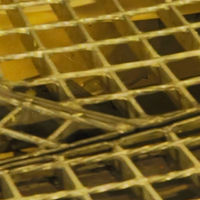

In [6]:
crop = list_crops[20000]
result = load_crop(crop,img_infos['paths'][crop[0]])
show_thumbnail(result)

### Affichages de quelques exemples de crops

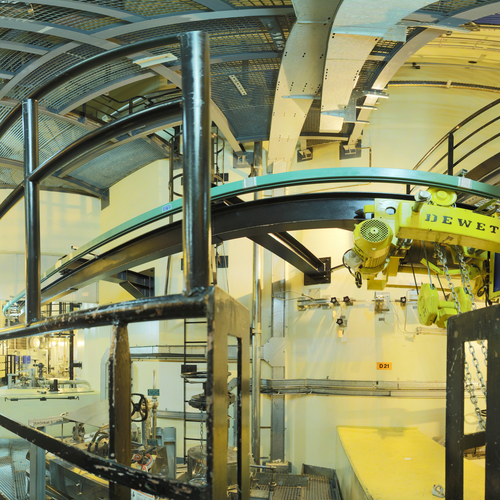

In [10]:
#(960, 230)
x = 1000
y = 2000
h = 10000
w = 10000

img_path = '/dds/work/workspace/data_ja/CAT_1_9024.jpg.ppm'
result = read_from_memory(img_path,x,y,w, h)
show_thumbnail(result,500)